In [1]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import math
from math import radians, sin, cos, sqrt
import os
import geopandas as gpd
import psycopg2
import ast
import matplotlib.pyplot as plt
import datetime
from psycopg2 import sql
from psycopg2.extras import Json
from shapely.geometry import LineString
from shapely import wkt
from shapely.geometry import Polygon
import json
from myutil import *
import myutil
from scipy.spatial import ConvexHull

from geopy.distance import great_circle
from scipy.spatial import kdtree
import rtree 
import pyqtree #point-quadtree
from quads import QuadTree
from pygeos import STRtree

d:\NewOne\UQ\INFS4205\assignment\taxi_trajectory\venv\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Acer\AppData\Local\Temp\ipykernel_428\3199885952.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://

In [2]:
# for test only
df = pd.read_csv('taxi_preprocessed.csv', nrows=1000)

In [2]:
df = pd.read_csv('taxi_preprocessed2.csv')

In [5]:
df = df.drop('Unnamed: 0', axis=1)

In [6]:
# save data with Date
df.to_csv("taxi_preprocessed2.csv", index= False)

In [4]:
df.columns

Index(['trip_id', 'call_type', 'origin_call', 'origin_stand', 'taxi_id',
       'timestamp', 'day_type', 'missing_data', 'polyline', 'distance', 'year',
       'month', 'day', 'hour', 'week_day', 'start_lat', 'start_long',
       'end_lat', 'end_long', 'geom', 'total_time'],
      dtype='object')

In [24]:
df.total_time.describe()

count    1.673787e+06
mean     7.321635e+02
std      6.838135e+02
min      1.500000e+01
25%      4.200000e+02
50%      6.150000e+02
75%      8.700000e+02
max      5.820000e+04
Name: total_time, dtype: float64

In [11]:
df = df.drop('missing_data', axis=1)

In [17]:
type(df.geom)

pandas.core.series.Series

In [16]:
# Convert pandas.core.series.Series to LineString (GeoSeries) format
df['geom'] = df['geom'].apply(lambda x: wkt.loads(x))

In [18]:
df = gpd.GeoDataFrame(df, geometry='geom')

In [9]:
#df.to_csv("taxi_proprocessed2.csv", index=False)

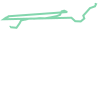

In [8]:
df['geom'][3]

In [2]:
df = pd.read_csv('train.csv')
df.columns = [c.lower() for c in df.columns] # PostgreSQL doesn't like capitals or spaces

In [29]:
df2 = pd.read_csv('train.csv')

In [198]:
df.head(5)

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,distance,...,day,hour,week_day,start_lat,start_long,end_lat,end_long,geom,total_time,isnotvalid
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2.651052,...,1,10,0,41.141412,-8.618643,41.154489,-8.630838,"LINESTRING (-8.61864 41.14141, -8.61850 41.141...",330,False
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",3.456273,...,1,10,0,41.159826,-8.639847,41.170671,-8.665740,"LINESTRING (-8.63985 41.15983, -8.64035 41.159...",270,False
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",17.630474,...,1,10,0,41.140359,-8.612964,41.140530,-8.615970,"LINESTRING (-8.61296 41.14036, -8.61338 41.140...",960,True
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",7.968056,...,1,10,0,41.151951,-8.574678,41.142915,-8.607996,"LINESTRING (-8.57468 41.15195, -8.57470 41.151...",630,True
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",4.814333,...,1,10,0,41.180490,-8.645994,41.178087,-8.687268,"LINESTRING (-8.64599 41.18049, -8.64595 41.180...",420,False


In [196]:
df2

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."
...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-..."
1710666,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[..."
1710667,1388745716620000264,C,NaN,NaN,20000264,1388745716,A,False,[]
1710668,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-..."


In [200]:
type(df['polyline'])

pandas.core.series.Series

In [31]:
df2.index.nunique()

1710670

In [12]:
df.shape

(1673787, 21)

In [8]:
df.columns

Index(['trip_id', 'call_type', 'origin_call', 'origin_stand', 'taxi_id',
       'timestamp', 'day_type', 'missing_data', 'polyline', 'distance', 'year',
       'month', 'day', 'hour', 'week_day', 'start_lat', 'start_long',
       'end_lat', 'end_long', 'geom', 'total_time'],
      dtype='object')

# Preprocessing on pandas

## Remove null values (missing_data == True and polyline == [])

In [15]:
df['taxi_id'].count()

1704759

In [10]:
df['taxi_id'].nunique()

448

In [12]:
df['missing_data'].describe()

count     1710670
unique          2
top         False
freq      1710660
Name: missing_data, dtype: object

In [13]:
# drop rows missing data
df.drop(df[df['missing_data'] == True].index, inplace=True)

In [28]:
df['trip_id'].count()

1704759

In [26]:
df[df.polyline == "[]"]

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline
762,1372665673620000353,C,NaN,NaN,20000353,1372665673,A,False,[]
1161,1372669158620000562,C,NaN,NaN,20000562,1372669158,A,False,[]
1459,1372665875620000496,C,NaN,NaN,20000496,1372665875,A,False,[]
1677,1372667320620000288,C,NaN,NaN,20000288,1372667320,A,False,[]
1719,1372676112620000600,C,NaN,NaN,20000600,1372676112,A,False,[]
...,...,...,...,...,...,...,...,...,...
1710547,1403120685620000226,A,26552.0,NaN,20000226,1403120685,A,False,[]
1710643,1386603894620000970,C,NaN,NaN,20000970,1386603894,A,False,[]
1710658,1373986578620000931,A,2002.0,NaN,20000931,1373986578,A,False,[]
1710664,1390403767620000911,C,NaN,NaN,20000911,1390403767,A,False,[]


In [27]:
# delete trips having no polyline.
df = df[df.polyline != "[]"]

In [91]:
df

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,distance,year,month,day,hour,week_day,start_lat,start_long,end_lat,end_long
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2.651052,2013,7,1,10,0,41.141412,-8.618643,41.154489,-8.630838
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",3.456273,2013,7,1,10,0,41.159826,-8.639847,41.170671,-8.665740
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",17.630474,2013,7,1,10,0,41.140359,-8.612964,41.140530,-8.615970
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",7.968056,2013,7,1,10,0,41.151951,-8.574678,41.142915,-8.607996
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",4.814333,2013,7,1,10,0,41.180490,-8.645994,41.178087,-8.687268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1704754,1388660427620000585,C,NaN,NaN,20000585,1388660427,A,False,"[[-8.60697,41.162283],[-8.60697,41.16231],[-8....",0.839418,2014,1,2,21,3,41.162283,-8.606970,41.162382,-8.608158
1704755,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",3.167715,2014,7,1,9,1,41.146020,-8.612469,41.171013,-8.611344
1704756,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",3.831307,2014,7,1,9,1,41.140845,-8.610138,41.158755,-8.627454
1704757,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",5.329792,2014,7,1,1,1,41.154885,-8.630712,41.173524,-8.587026


## Calculate distance using great_circle fomula

$$
d=r \cos ^{-1}[\cos a \cos b \cos (x-y)+\sin a \sin b]
$$
    r = Radius of the Earth 
    a, b = latitude 
    x, y = longitude 

In [5]:
myutil.calculate_distance_polyline(myutil.swap_long_lat(df['polyline'][5]))

5.569622808966026

Create a new column contaning distance traveled by a taxi according to its list of coordinates.

In [73]:
# 36m 8.9s
df['distance'] = df['polyline'].apply(myutil.swap_long_lat).apply(myutil.calculate_distance_polyline)

In [74]:
df.head()

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,distance
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2.651052
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",3.456273
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",17.630474
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",7.968056
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",4.814333


### Delete the trips having distance less than 0.4
Eliminate the trips that have the total distance less than 0.3km. Because I have a lot of data, my computer can't process the large amount of data, so I need to reduce some less important records, and the trips having distance less than 0.4 do not have a lot of meaning I think. Morover, I can avoid the case when a taxi connect the GPS but didnt moving.

In [91]:
df[df['distance'] < 0.4].sort_values('distance', ascending=False).shape

(0, 21)

In [11]:
df[df['distance'] < 0.4].sort_values('distance', ascending=False).shape

(24414, 21)

In [12]:
print(df.shape)
df = df[df['distance'] >= 0.4] 
print(df.shape)

(1673787, 21)
(1649373, 21)


In [13]:
# save data with distances
df.to_csv("taxi_preprocessed2.csv")

## Convert polyline (string) to LineString (PostGis).

In [11]:
df['lines'] = df['polyline'].apply(json.loads)

In [ ]:
df['lines'] = df['polyline'].apply(lambda x: ast.literal_eval(x))

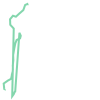

In [5]:
LineString(myutil.swap_long_lat(df['polyline'][3]))

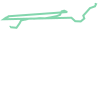

In [4]:
LineString(json.loads(df['polyline'][3]))

In [14]:
df['geom'] = df['polyline'].apply(json.loads).apply(lambda x: LineString(x))

In [15]:
df.head()

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,distance,year,month,day,hour,week_day,start_lat,start_long,end_lat,end_long,geom
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2.651052,2013,7,1,10,0,41.141412,-8.618643,41.154489,-8.630838,"LINESTRING (-8.618643 41.141412, -8.618499 41...."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",3.456273,2013,7,1,10,0,41.159826,-8.639847,41.170671,-8.665740,"LINESTRING (-8.639847 41.159826, -8.640351 41...."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",17.630474,2013,7,1,10,0,41.140359,-8.612964,41.140530,-8.615970,"LINESTRING (-8.612964 41.140359, -8.613378 41...."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",7.968056,2013,7,1,10,0,41.151951,-8.574678,41.142915,-8.607996,"LINESTRING (-8.574678 41.151951, -8.574705 41...."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",4.814333,2013,7,1,10,0,41.180490,-8.645994,41.178087,-8.687268,"LINESTRING (-8.645994 41.18049, -8.645949 41.1..."


In [19]:
df.to_csv('taxi_preprocessed2.csv', index=False)

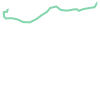

In [18]:
df['geom'][4]

## Take the start and end coordinates of each polyline

In [31]:
print("Start at: ", myutil.swap_long_lat(df['polyline'][3])[0])
print("End at: ", myutil.swap_long_lat(df['polyline'][3])[-1])

Start at:  [41.151951, -8.574678]
End at:  [41.142915, -8.607996]


In [35]:
myutil.swap_long_lat(df['polyline'][3])[0][1]

-8.574678

In [36]:
df['start_lat'] = df['polyline'].apply(lambda x: myutil.swap_long_lat(x)[0][0])
df['start_long'] = df['polyline'].apply(lambda x: myutil.swap_long_lat(x)[0][1])
df['end_lat'] = df['polyline'].apply(lambda x: myutil.swap_long_lat(x)[-1][0])
df['end_long'] = df['polyline'].apply(lambda x: myutil.swap_long_lat(x)[-1][1])

In [37]:
df.head()

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,distance,year,month,day,hour,week_day,start_lat,start_long,end_lat,end_long
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2.651052,2013,7,1,10,0,41.141412,-8.618643,41.154489,-8.630838
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",3.456273,2013,7,1,10,0,41.159826,-8.639847,41.170671,-8.665740
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",17.630474,2013,7,1,10,0,41.140359,-8.612964,41.140530,-8.615970
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",7.968056,2013,7,1,10,0,41.151951,-8.574678,41.142915,-8.607996
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",4.814333,2013,7,1,10,0,41.180490,-8.645994,41.178087,-8.687268


In [38]:
df.to_csv('taxi_preprocessed2.csv', index=False)

## Convert Timestamp to Date

In [8]:
datetime.datetime.fromtimestamp(df['timestamp'][74259]).weekday()

1

In [9]:
df['year'] = df['timestamp'].apply(lambda x :datetime.datetime.fromtimestamp(x).year) 
df['month'] = df['timestamp'].apply(lambda x :datetime.datetime.fromtimestamp(x).month) 
df['day'] = df['timestamp'].apply(lambda x :datetime.datetime.fromtimestamp(x).day) 
df['hour'] = df['timestamp'].apply(lambda x :datetime.datetime.fromtimestamp(x).hour) 
df['week_day'] = df['timestamp'].apply(lambda x :datetime.datetime.fromtimestamp(x).weekday()) 

In [10]:
df.head()

,Unnamed: 0,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,distance,year,month,day,hour,week_day
0,0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2.651052,2013,7,1,10,0
1,1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",3.456273,2013,7,1,10,0
2,2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",17.630474,2013,7,1,10,0
3,3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",7.968056,2013,7,1,10,0
4,4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",4.814333,2013,7,1,10,0


In [11]:
# save data with Date
df.to_csv("taxi_preprocessed2.csv", index= False)

## Drop records having start point equals to end point (didn't move)

In [107]:
df.loc[(df['start_lat'] == df['end_lat']) & (df['start_long'] == df['end_long'])]

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,distance,year,month,day,hour,week_day,start_lat,start_long,end_lat,end_long


In [ ]:
df.iloc[1704717]

In [94]:
df = df.loc[(df['start_lat'] != df['end_lat']) | (df['start_long'] != df['end_long'])]

In [34]:
# save data with Date
df.to_csv("taxi_preprocessed2.csv", index= False)

## Detect Invalid GPS

Assume that a taxi moves with uniform velocity on the plane, we have the distance:
$$
distance = \frac{velocity * time}{3600}  (km)
$$

In [19]:
ast.literal_eval(df['polyline'][3])[0]

[-8.574678, 41.151951]

In [19]:
def is_valid_filter1(polyline, threshold=0.51):
    """Check is the trip valid or not. Assume that the distribution is in Normal distribution.
    
    Args:
        polyline (list): list of coordinates
        threshold (float, optional): The maximum distance a vehicle traveling in 15 seconds with a constant velocity. 
        Defaults to 0.51 (velocity is 120 km/h)

    Returns:
        boolean: True if it's valid, False if it's invalid
    """
    line = ast.literal_eval(polyline)
    distances = [great_circle(line[i], line[i+1]) for i in range(len(line)-1)]
    q1, q3 = np.percentile(distances, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    #outliers = [dist for dist in distances if dist > upper_bound and dist > threshold]
    # di len 1 lan
    for dist in distances:
        if (dist > upper_bound and dist > threshold):
           return False
        
    return True


In [90]:
def is_valid_filter2(polyline, threshold=0.51, threshhold2 = 1.04):
    """Check is the trip valid or not. Assume that the distribution is in Normal distribution.
    
    Args:
        polyline (list): list of coordinates
        threshold (float, optional): The maximum distance a vehicle traveling in 15 seconds with a constant velocity. Defaults to 0.51 (velocity is around 120 km/h)
        threshold2 (float, optional): The length of the Ceuta tunnel.

    Returns:
        boolean: True if it's valid, False if it's invalid
    """
    line = ast.literal_eval(polyline)
    distances = [great_circle(line[i], line[i+1]) for i in range(len(line)-1)]
    q1, q3 = np.percentile(distances, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    #outliers = [dist for dist in distances if dist > upper_bound and dist > threshold]
    count = 0
    for dist in distances:
        if (dist > upper_bound and dist > threshold):
            count += 1
        if (count == 2 or dist > threshhold2):
            return False
    
    return True


In [15]:
max_great_circle_distance(df['polyline'][625])

3.24813722548608

In [298]:
is_valid_filter1(df['polyline'][625])

True

In [23]:
df_filter2 = df.loc[df['polyline'].apply(lambda x: is_valid_filter2(x)) == False].index

In [83]:
type(df_filter2)

pandas.core.indexes.base.Index

In [59]:
df_filter2

Index([      2,       3,      15,      56,      58,      63,      79,      85,
           100,     104,
       ...
       1673673, 1673674, 1673689, 1673691, 1673697, 1673726, 1673733, 1673759,
       1673781, 1673784],
      dtype='int64', length=120126)

In [24]:
df_invalid_coordinates = pd.read_csv('invalid_records_idx.csv')
df_invalid_coordinates.head()

,invalid_idx
0,2
1,3
2,15
3,56
4,58


In [41]:
df.shape

(1649373, 21)

In [ ]:
myutil.get_bounding_box(swap_long_lat(df['polyline'][3]))

[[41.142555, -8.610849], [41.15196, -8.57466]]

In [ ]:
plyline = df['polyline'][157]
print("Max_dist: ", max_great_circle_distance(plyline))
print("Mean_dist: ", mean_great_circle_distance(plyline))


Max_dist:  0.12372156457451271
Mean_dist:  0.05225097683378197


In [ ]:
# list of indices that the taxis go through the tunnel.
indices = [29, 31, 60, 79, 105, 120, 176, 194, 250, 251, 253, 361, 370, 377, 405, 429, 450, 451, 454, 455, 465, 476, 490, 492, 504, 518, 545, 546, 589, 594, 597, 602, 611, 641, 645, 691, 702]

# list to store max great circle distances
max_distances = []
mean_distances = []

# iterate over indices and calculate max great circle distance for each
for index in indices:
    max_distance = max_great_circle_distance(df['polyline'][index])
    mean_distance = max_great_circle_distance(df['polyline'][index])
    max_distances.append(max_distance)
    mean_distances.append(mean_distance)


# print max distances with indices
for index, max_distance, mean_distance in zip(indices, max_distances, mean_distances):
    print(f"Index: {index}, Max Distance: {max_distance}, Mean Distance: {mean_distance}")

print("Min Max: ", np.min(max_distances))
print("Avg Max: ", np.mean(max_distances))
print("Max Max: ", np.max(max_distances))



Index: 29, Max Distance: 0.8236250667195826, Mean Distance: 0.8236250667195826
Index: 31, Max Distance: 0.8004947709140369, Mean Distance: 0.8004947709140369
Index: 60, Max Distance: 0.9698002292956177, Mean Distance: 0.9698002292956177
Index: 79, Max Distance: 1.0009299225936998, Mean Distance: 1.0009299225936998
Index: 105, Max Distance: 0.976634727673206, Mean Distance: 0.976634727673206
Index: 120, Max Distance: 0.9185892694010558, Mean Distance: 0.9185892694010558
Index: 176, Max Distance: 0.9821606438948868, Mean Distance: 0.9821606438948868
Index: 194, Max Distance: 0.8146175870358203, Mean Distance: 0.8146175870358203
Index: 250, Max Distance: 1.0383158338778524, Mean Distance: 1.0383158338778524
Index: 251, Max Distance: 0.8026158728159073, Mean Distance: 0.8026158728159073
Index: 253, Max Distance: 0.7590089671410659, Mean Distance: 0.7590089671410659
Index: 361, Max Distance: 1.0223249544748978, Mean Distance: 1.0223249544748978
Index: 370, Max Distance: 1.0517788189913273, 

The averange distance when a taxis went through to the tunnel is 0.93 -> this may be the distance of the tunnel

In [ ]:
df['polyline'][176]

In [ ]:
df_mindist = df[df['distance'] < 0.4].sort_values('distance', ascending=False)

In [53]:
is_valid_filter2(df['polyline'][692])

True

In [80]:
max_great_circle_distance(df['polyline'][1000])

1.0272172070071888

In [ ]:
df_mindist.shape

(0, 20)

In [9]:
# this trip is valid
myutil.create_map(myutil.swap_long_lat(df['polyline'][19]))

Base on Google Map and the avarage distance when travelling through Túnel de Ceuta, Porto calculated above, the mean distance are around 0.75m and 0.93km respectively (in 40 samples). It seems correct because the GPS coordinates recorded are not exactly at the start and the end points of the tunnel. Therefore, I take the threshold 1.04km to filter these cases.

In [22]:
# this trip went through the tunnel
myutil.create_map(myutil.swap_long_lat(df['polyline'][31]))

In [23]:
# this trip is invalid
myutil.create_map(myutil.swap_long_lat(df['polyline'][689]))

In [56]:
#create_map(myutil.swap_long_lat(records[15][9]))
# 730
# max valid distance recorded: 0.5193072203547056  - 47
# Valid: 47 73 104 139 144 156 157 209 210 309 338 339 363 414 423 479 497 581 583 671
# Almadas Tunnel/ Túnel de Ceuta: 29 31 60 79 105 120 176 194 250 251 253 361 370 377 405 429 450 451 454 455 465 476 490 492 504 518 545 546 589 594 597 602 611 645 691 702 
# das Antas I Tunnel: 156 ?
# weird: 689

# detected first 100 invalid trips' indecies
# 2,    3,   55,   15,   57,   62,   83,   97,  101,  122,  139,  156,
#        178,  203,  204,  220,  254,  283,  291,  300,  313,  333,  348,  363,
#        398,  412,  417,  442,  457,  506,  521,  542,  553,  558,  574,  575,
#        591,  595,  617,  641,  658,  662,  665,  681,  692,  704,  711,  721,
#        787,  800,  813,  816,  828,  839,  851,  927,  954,  955,  972,  990,
#       1018, 1032, 1062, 1085, 1093, 1114, 1117, 1138, 1148, 1158, 1163, 1170,
#       1189, 1225, 1232, 1241, 1248, 1250, 1252, 1350, 1351, 1353, 1374, 1378,
#       1384, 1387, 1389, 1401, 1402, 1411, 1420, 1467, 1472, 1474, 1513, 1533,
#       1546, 1566, 1569, 1576

#[   2,    3,   15,   56,   58,   63,   79,   85,  100,  104,  125,  142,
#        159,  181,  209,  210,  212,  220,  226,  250,  260,  289,  297,  306,
#        319,  339,  354,  361,  369,  370,  377,  383,  404,  405,  418,  423,
#        429,  448,  450,  455,  463,  476,  512,  528,  549,  561,  566,  582,
#        583,  594,  597,  599,  603,  611,  625,  641,  645,  649,  667,  671,
#        674,  689,  690,  701,  711,  713,  720,  722,  723,  730,  732,  734,
#        757,  796,  806,  810,  816,  823,  827,  837,  839,  850,  862,  923,
#        924,  931,  934,  941,  968,  969,  976,  986, 1000, 1004, 1008, 1030,
#       1034, 1048, 1063, 1068]

#   I did this task on Google Collaboration. See other .ipynb file
#[   2,    3,   15,   55,   57,   62,   83,   97,  101,  122,  139,
#             156,  178,  203,  204,  206,  214,  220,  254,  283,  291,  300,
#             313,  333,  348,  363,  364,  377,  398,  412,  417,  423,  442,
#             449,  457,  470,  506,  521,  542,  553,  558,  574,  575,  591,
#             595,  617,  633,  641,  658,  662,  665,  680,  681,  692,  704,
#             711,  713,  714,  721,  723,  748,  787,  796,  800,  806,  813,
#             816,  826,  828,  839,  851,  910,  911,  917,  927,  954,  955,
#             962,  972,  990,  994, 1015, 1018, 1032, 1052, 1062, 1082, 1085,
#            1093, 1110, 1114, 1117, 1135, 1138, 1140, 1148, 1158, 1159, 1160,
#            1163]

# Taxi GPS was disconnectd when traveling in Almadas Tunnel
# example for an invalid trip
myutil.create_map(myutil.swap_long_lat(df['polyline'][62]))

# Finalize the data before importing to database

#

In [2]:
df2 = pd.read_csv("taxi_preprocessed3.csv")
df2.head()

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,day_type,missing_data,polyline,distance,...,month,day,hour,week_day,start_lat,start_long,end_lat,end_long,geom,total_time
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2.651052,...,7,1,10,0,41.141412,-8.618643,41.154489,-8.630838,"LINESTRING (-8.618643 41.141412, -8.618499 41....",330
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",3.456273,...,7,1,10,0,41.159826,-8.639847,41.170671,-8.665740,"LINESTRING (-8.639847 41.159826, -8.640351 41....",270
2,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",4.814333,...,7,1,10,0,41.180490,-8.645994,41.178087,-8.687268,"LINESTRING (-8.645994 41.18049, -8.645949 41.1...",420
3,1372636965620000231,C,NaN,NaN,20000231,1372636965,A,False,"[[-8.615502,41.140674],[-8.614854,41.140926],[...",5.569623,...,7,1,10,0,41.140674,-8.615502,41.160717,-8.578224,"LINESTRING (-8.615502 41.140674, -8.614854 41....",375
4,1372637210620000456,C,NaN,NaN,20000456,1372637210,A,False,"[[-8.57952,41.145948],[-8.580942,41.145039],[-...",3.444482,...,7,1,10,0,41.145948,-8.579520,41.142816,-8.603973,"LINESTRING (-8.57952 41.145948, -8.580942 41.1...",525


In [4]:
df2.missing_data.value_counts()

missing_data
False    1559706
Name: count, dtype: int64

In [12]:
df2.columns

Index(['trip_id', 'call_type', 'origin_call', 'origin_stand', 'taxi_id',
       'timestamp', 'day_type', 'missing_data', 'polyline', 'distance', 'year',
       'month', 'day', 'hour', 'week_day', 'start_lat', 'start_long',
       'end_lat', 'end_long', 'geom', 'total_time'],
      dtype='object')

In [5]:
# these columns used for analysis, but we dont need to import to database
df3 = df2.drop(['missing_data', 'year', 'month', 'day', 'hour', 'week_day'], axis=1)

In [11]:
df3.columns

Index(['trip_id', 'call_type', 'origin_call', 'origin_stand', 'taxi_id',
       'timestamp', 'day_type', 'polyline', 'distance', 'start_lat',
       'start_long', 'end_lat', 'end_long', 'geom', 'total_time'],
      dtype='object')

In [13]:
df3.shape

(1559706, 15)

In [14]:
# cut down to 1 million records because my computer is weak
df3.head(1000000).to_csv("final_data.csv", index=False)

In [8]:
df3.shape

(1559706, 15)

In [5]:
df3['trip_id'].nunique()

999999

In [2]:
df3 = pd.read_csv("final_data.csv")

In [3]:
split1 = df3.iloc[:100000]
split2 = df3.iloc[100000:200000]
split3 = df3.iloc[200000:300000]
split4 = df3.iloc[300000:400000]
split5 = df3.iloc[400000:500000]
split6 = df3.iloc[500000:600000]
split7 = df3.iloc[700000:800000]
split8 = df3.iloc[800000:900000]
split9 = df3.iloc[900000:]

In [4]:
split1.to_csv("split1.csv", index=False)
split2.to_csv("split2.csv", index=False)
split3.to_csv("split3.csv", index=False)
split4.to_csv("split4.csv", index=False)
split5.to_csv("split5.csv", index=False)
split6.to_csv("split6.csv", index=False)
split7.to_csv("split7.csv", index=False)
split8.to_csv("split8.csv", index=False)
split9.to_csv("split9.csv", index=False)
